In [16]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,date,timedelta
import json

from ta.utils import dropna
import ta.trend as ta_trend
import ta.momentum as ta_mmt
import ta.others as ta_other
import ta 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tensorflow.keras.models import load_model
import joblib

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound
from google.api_core.exceptions import BadRequest

# Declare and Initialize Variable

In [17]:

today='2023-04-28'

AssetName="SPY"

date_col='Date'
prediction_col='EMA1'
feature_cols=['EMA1']

input_sequence_length =60
output_sequence_length =10

nLastData=input_sequence_length+int(input_sequence_length/2)


colInput='feature'
colOutput='prediction'



# BigQuery Setting

In [18]:

json_credential_file=r'C:\Windows\pongthorn-5decdc5124f5.json'
projectId='pongthorn'
dataset_id='FinAssetForecast'
table_id = f"{projectId}.{dataset_id}.fin_movement_forecast"
table_data_id = f"{projectId}.{dataset_id}.fin_data"

print(table_id)
print(table_data_id)

credentials = service_account.Credentials.from_service_account_file(json_credential_file)
client = bigquery.Client(project=projectId,credentials=credentials )

pongthorn.FinAssetForecast.fin_movement_forecast
pongthorn.FinAssetForecast.fin_data


# Query Fin Data from BQ

In [19]:
sql=f"""
SELECT  *  FROM `{table_data_id}`  
Where  {date_col} between  DATE_SUB(DATE '{today}', INTERVAL {nLastData} DAY) 
and '{today}' and Symbol='{AssetName}' order by {date_col}
"""
print(sql)
query_result=client.query(sql)
df=query_result.to_dataframe()

df[date_col]=pd.to_datetime(df[date_col],format='%Y-%m-%d')
df.set_index(date_col,inplace=True)

print(df.info())

df.tail()


SELECT  *  FROM `pongthorn.FinAssetForecast.fin_data`  
Where  Date between  DATE_SUB(DATE '2023-04-28', INTERVAL 90 DAY) 
and '2023-04-28' and Symbol='SPY' order by Date

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2023-01-30 to 2023-04-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  63 non-null     object 
 1   Close   63 non-null     float64
 2   EMA1    63 non-null     float64
 3   EMA2    63 non-null     float64
 4   MACD    63 non-null     float64
 5   SIGNAL  63 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.4+ KB
None


,Symbol,Close,EMA1,EMA2,MACD,SIGNAL
Date,,,,,,
2023-04-24,SPY,412.63,411.6727,408.7760,2.8967,2.7027
2023-04-25,SPY,406.08,410.6558,408.5192,2.1366,2.6319
2023-04-26,SPY,404.36,409.5111,408.1231,1.3880,2.4765
2023-04-27,SPY,412.41,410.0382,408.5314,1.5068,2.3552
2023-04-28,SPY,415.93,411.1094,409.2360,1.8734,2.2950


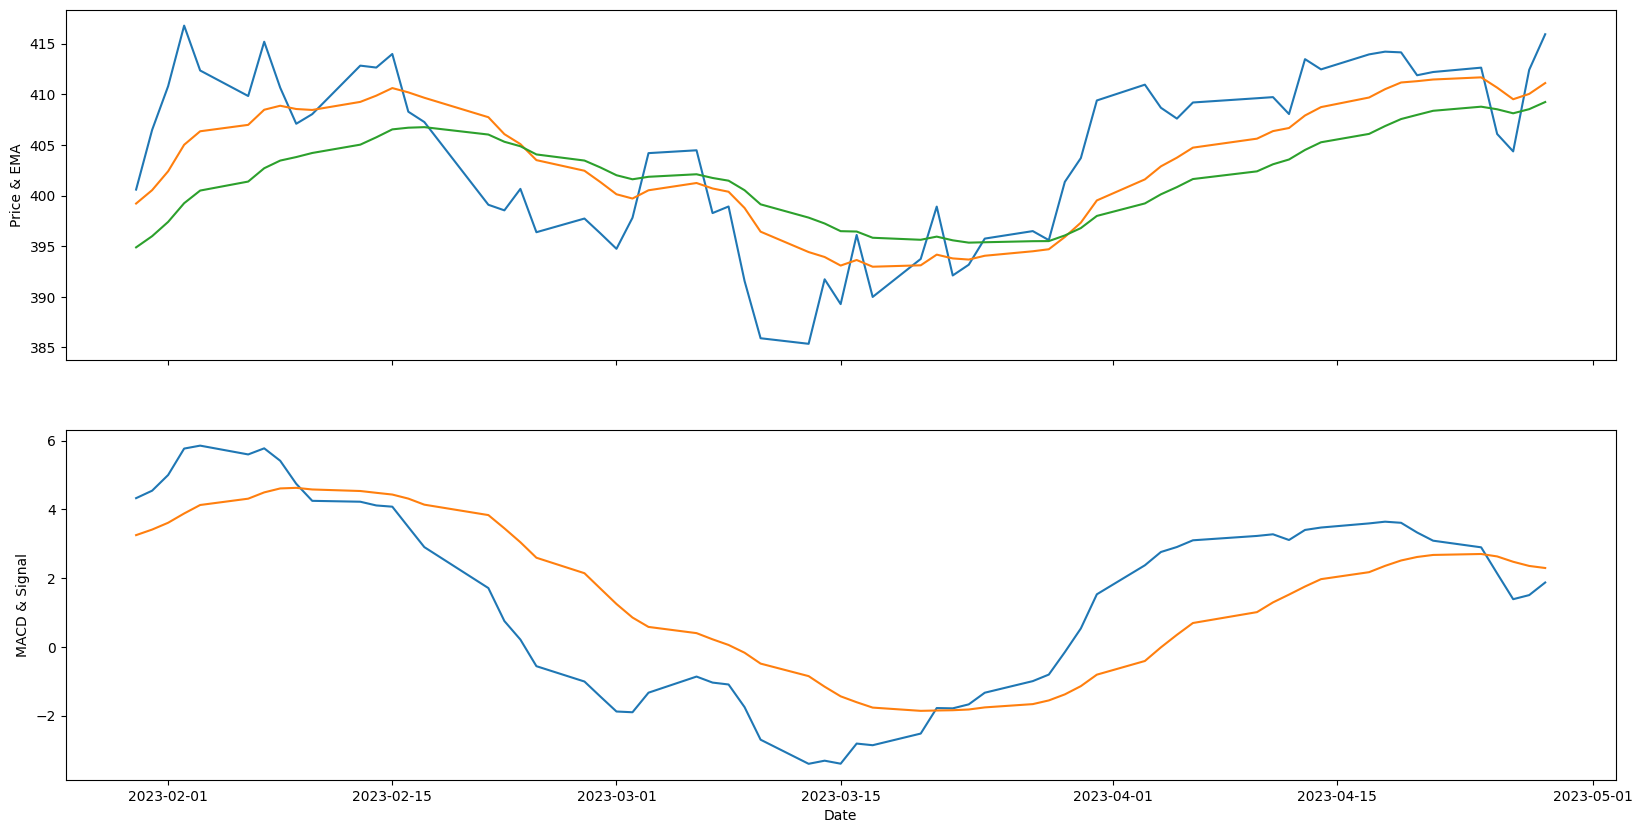

In [20]:
plt.subplots(2, 1, figsize = (20, 10),sharex=True)

ax1 = plt.subplot(2, 1, 1)
plt.plot(df[['Close','EMA1','EMA2']])
plt.ylabel('Price & EMA')

ax2 = plt.subplot(2, 1, 2)
plt.plot(df[['MACD','SIGNAL']])
plt.xlabel('Date')
plt.ylabel('MACD & Signal')

plt.show()

# Load model and scaler

In [21]:
print("Load model and scaler")
x_model = load_model("model/EMA1_60To10_SPY_E150S20-Y2015-2023_ma.h5")
x_scaler = joblib.load("model/scaler_EMA1_60To10_SPY_E150S20-Y2015-2023.gz")
x_scalerPred=joblib.load("model/scaler_pred_EMA1_60To10_SPY_E150S20-Y2015-2023.gz")



# x_model = load_model("model/best_tune_EMA1_60To10_SPY_E150S15-Y2015-2023.h5")
# x_scaler = joblib.load("model/scaler_best_tune_EMA1_60To10_SPY_E150S15-Y2015-2023.gz")
# x_scalerPred=joblib.load("model/scaler_pred_best_tune_EMA1_60To10_SPY_E150S15-Y2015-2023.gz")

print("Model and Scaler Object Summary")
print(x_model.summary())

#(max - min) / (X.max(axis=0) - X.min(axis=0))
print(f"max={x_scaler.data_max_} and min={x_scaler.data_min_} and scale={x_scaler.scale_}")
print(f"max={x_scalerPred.data_max_} and min={x_scalerPred.data_min_} and scale={x_scalerPred.scale_}")

Load model and scaler
Model and Scaler Object Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 180)               131040    
                                                                 
 dropout_1 (Dropout)         (None, 180)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1810      
                                                                 
Total params: 132,850
Trainable params: 132,850
Non-trainable params: 0
_________________________________________________________________
None
max=[473.99] and min=[187.09] and scale=[0.00348554]
max=[473.99] and min=[187.09] and scale=[0.00348554]


D:\ProgramData\Anaconda3\envs\google_base\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Get only Feature to Predict itself in the next N days

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2023-02-02 to 2023-04-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes
None
(60, 1)
                EMA1
Date                
2023-02-02  405.0143
2023-02-03  406.3481
2023-02-06  406.9812
2023-02-07  408.4737
2023-02-08  408.8694
                EMA1
Date                
2023-04-24  411.6727
2023-04-25  410.6558
2023-04-26  409.5111
2023-04-27  410.0382
2023-04-28  411.1094


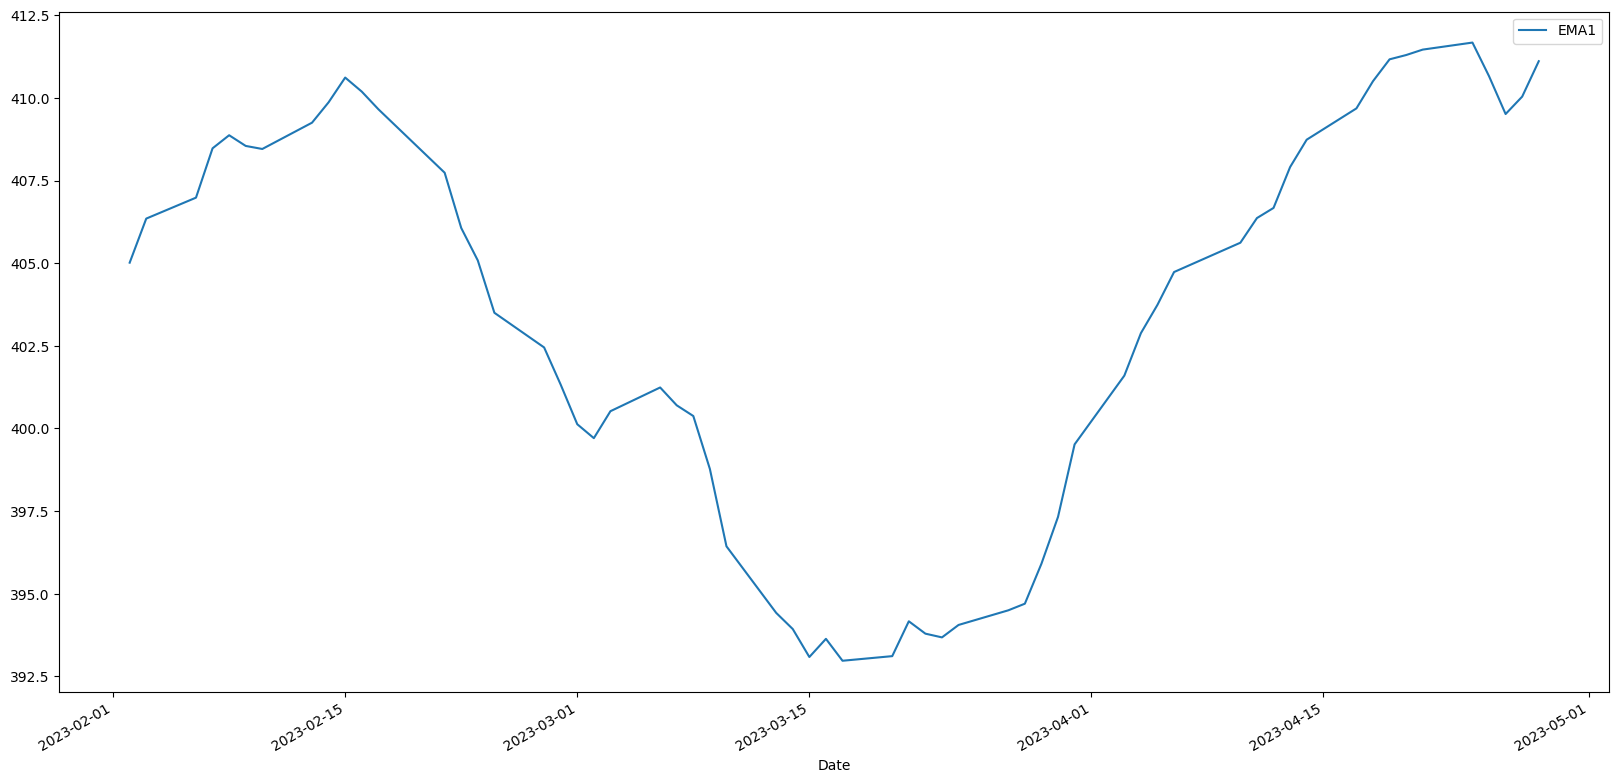

In [22]:
# get data last 60 days (select * from table limit 60) to predict tomorow at 
# 12:00 For S&P
# 08:00 For SET Thailand

dfForPred=df[feature_cols]
#dfForPred=dfForPred.iloc[-(input_sequence_length+1):-1,:]
dfForPred=dfForPred.iloc[-input_sequence_length:,:]
print(dfForPred.info())
print(dfForPred.shape)

print(dfForPred.head(5))
print(dfForPred.tail(5))


dfForPred.plot(figsize = (20, 10))
plt.show()

# Make Pediction

In [23]:
xUnscaled=dfForPred.values #print(xUnscaled.shape)
xScaled=x_scaler.transform(xUnscaled)
print(xScaled.shape)
print(xScaled[-5:])

# # Way1
# xScaledToPredict = []
# xScaledToPredict.append(xScaled)
# print(len(xScaledToPredict))

# yPredScaled=x_model.predict(np.array(xScaledToPredict))
# print(yPredScaled.shape,yPredScaled)

# yPred  = x_scalerPred.inverse_transform(yPredScaled.reshape(-1, 1))
# print(yPred.shape,yPred)

#Way2
xScaledToPredict= xScaled.reshape(1,input_sequence_length,len(feature_cols))
print(xScaledToPredict.shape)

yPredScaled = x_model.predict(xScaledToPredict)
print(yPredScaled.shape, yPredScaled)

yPred = x_scalerPred.inverse_transform(yPredScaled).reshape(-1, 1)
print(yPred.shape, yPred)


print("============================Summary============================")
print(xUnscaled.shape)
print(yPred.shape)

# print("============================Input============================")
# print(xUnscaled)
# print("============================Output============================")
# print(yPred)



(60, 1)
[[0.78279087]
 [0.77924643]
 [0.77525654]
 [0.77709376]
 [0.78082747]]
(1, 60, 1)
1/1 [==============================] - 1s 510ms/step
(1, 10) [[0.7905763  0.7811429  0.7845317  0.78248376 0.7993978  0.78919804
  0.78910875 0.7928916  0.7923099  0.7927757 ]]
(10, 1) [[413.90634]
 [411.1999 ]
 [412.17215]
 [411.5846 ]
 [416.43726]
 [413.51093]
 [413.48532]
 [414.57062]
 [414.40372]
 [414.53735]]
============================Summary============================
(60, 1)
(10, 1)


# Build Predition Result Data

## Feature Data

In [24]:
dfFeature=pd.DataFrame(data= xUnscaled,columns=feature_cols,index=dfForPred.index)
dfFeature['Type']=colInput
print(dfFeature.shape)
print(dfFeature.head())
print(dfFeature.tail())

(60, 2)
                EMA1     Type
Date                         
2023-02-02  405.0143  feature
2023-02-03  406.3481  feature
2023-02-06  406.9812  feature
2023-02-07  408.4737  feature
2023-02-08  408.8694  feature
                EMA1     Type
Date                         
2023-04-24  411.6727  feature
2023-04-25  410.6558  feature
2023-04-26  409.5111  feature
2023-04-27  410.0382  feature
2023-04-28  411.1094  feature


## Forecast Value Data

In [25]:
lastRowOfFeature=dfFeature.index.max()
firstRowofPrediction=lastRowOfFeature+timedelta(days=1)
datePred=pd.date_range(start=firstRowofPrediction,freq='b',periods=output_sequence_length)
print(datePred)


DatetimeIndex(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04',
               '2023-05-05', '2023-05-08', '2023-05-09', '2023-05-10',
               '2023-05-11', '2023-05-12'],
              dtype='datetime64[ns]', freq='B')


In [26]:
dfPrediction=pd.DataFrame(data= yPred,columns=feature_cols,index=datePred)
dfPrediction.index.name=date_col
dfPrediction['Type']=colOutput
print(dfPrediction.shape)
print(dfPrediction)

(10, 2)
                  EMA1        Type
Date                              
2023-05-01  413.906342  prediction
2023-05-02  411.199890  prediction
2023-05-03  412.172150  prediction
2023-05-04  411.584595  prediction
2023-05-05  416.437256  prediction
2023-05-08  413.510925  prediction
2023-05-09  413.485321  prediction
2023-05-10  414.570618  prediction
2023-05-11  414.403717  prediction
2023-05-12  414.537354  prediction


# To ingest data into BQ , we have to create dataframe and convert to Json-Rowns

In [27]:
outputDF=pd.DataFrame(data=[ [today,AssetName,prediction_col] ],columns=["prediction_date","asset_name","prediction_name"])
print(outputDF)

jsonOutput = json.loads(outputDF.to_json(orient = 'records'))
for item in jsonOutput:
    
    dataFeature=dfFeature.reset_index()[[date_col,prediction_col]]
    dataFeature[date_col]=dataFeature[date_col].dt.strftime('%Y-%m-%d')
    dataFeature.columns=["input_date","input_feature"]
    jsonFeature= json.loads(dataFeature.to_json(orient = 'records'))
    item["feature_for_prediction"]=jsonFeature
    
    dataPred=dfPrediction.reset_index()[[date_col,prediction_col]]
    dataPred[date_col]=dataPred[date_col].dt.strftime('%Y-%m-%d')
    dataPred.columns=["output_date'","output_value"]
    jsonPred= json.loads(dataPred.to_json(orient = 'records'))
    item["prediction_result"]=jsonPred
 
with open("fin_prediction.json", "w") as outfile:
    json.dump(jsonOutput, outfile)
jsonOutput

  prediction_date asset_name prediction_name
0      2023-04-28        SPY            EMA1


[{'prediction_date': '2023-04-28',
  'asset_name': 'SPY',
  'prediction_name': 'EMA1',
  'feature_for_prediction': [{'input_date': '2023-02-02',
    'input_feature': 405.0143},
   {'input_date': '2023-02-03', 'input_feature': 406.3481},
   {'input_date': '2023-02-06', 'input_feature': 406.9812},
   {'input_date': '2023-02-07', 'input_feature': 408.4737},
   {'input_date': '2023-02-08', 'input_feature': 408.8694},
   {'input_date': '2023-02-09', 'input_feature': 408.5459},
   {'input_date': '2023-02-10', 'input_feature': 408.4539},
   {'input_date': '2023-02-13', 'input_feature': 409.2495},
   {'input_date': '2023-02-14', 'input_feature': 409.866},
   {'input_date': '2023-02-15', 'input_feature': 410.614},
   {'input_date': '2023-02-16', 'input_feature': 410.1896},
   {'input_date': '2023-02-17', 'input_feature': 409.657},
   {'input_date': '2023-02-21', 'input_feature': 407.7357},
   {'input_date': '2023-02-22', 'input_feature': 406.0638},
   {'input_date': '2023-02-23', 'input_feature

# Ingest Data to BigQuery 

In [28]:
# table=client.get_table(table_id)
# print("Table {} already exists.".format(table_id))
# table.schema
job_config = bigquery.LoadJobConfig(
# schema=[
#     bigquery.SchemaField("prediction_date", "DATE", mode="REQUIRED"),
#     bigquery.SchemaField("asset_name", "STRING", mode="REQUIRED"),
#     bigquery.SchemaField("prediction_name", "STRING", mode="REQUIRED"),
    
#     bigquery.SchemaField("feature_for_prediction","RECORD", mode="REPEATED",
#     fields=[ 
#          bigquery.SchemaField("input_date", "DATE", mode="REQUIRED"),
#          bigquery.SchemaField("input_feature", "FLOAT", mode="REQUIRED")]
#     ),    
#     bigquery.SchemaField("prediction_result","RECORD", mode="REPEATED",
#      fields=[ 
#       bigquery.SchemaField("output_date", "DATE", mode="REQUIRED"),
#       bigquery.SchemaField("output_value", "FLOAT", mode="REQUIRED")]
#     ),   
# ]
)

job_config.source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND  
#job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
#job_config.schema

In [29]:
job = client.load_table_from_json(jsonOutput,table_id, job_config = job_config)
if job.errors is not None:
    print(job.error_result)
    print(job.errors)
else:
    print(f"import to bigquery successfully  {len(jsonOutput)} records")

import to bigquery successfully  1 records
